# Import and Load Datasets

In [1]:

import nltk
nltk.download("all")
import torch
from datasets import load_dataset

import numpy as np

seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/kai-yi/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /home/kai-
[nltk_data]    |     yi/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/kai-yi/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/kai-yi/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/kai-yi/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_da

In [2]:
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset["train"]
validation_dataset = dataset["validation"]
test_dataset = dataset["test"]

In [3]:
train_dataset[0]['text']

'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .'

# Tokenization and Stopword Removal

In [4]:
from nltk.tokenize import word_tokenize

def tokenize(text):
    tokens = word_tokenize(text.lower())
    tokens_l = []

    for t in tokens:
        if "-" in t:  # Split hyphenated words
            parts = t.split('-')
            tokens_l.extend(parts)
        else:
            tokens_l.append(t)

    tokens_l = [word for word in tokens_l if word.isalnum()]

    return tokens_l



In [5]:
from nltk.corpus import stopwords

def tokenize_removestops(text):
    stop_words = set(stopwords.words('english'))
    tokens_l = tokenize(text)
    tokens_l = [w for w in tokens_l if w not in stop_words]
    return tokens_l

In [6]:
print(tokenize(train_dataset[0]['text']))
print(tokenize_removestops(train_dataset[0]['text']))

['the', 'rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'century', 'new', 'conan', 'and', 'that', 'he', 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'arnold', 'schwarzenegger', 'jean', 'claud', 'van', 'damme', 'or', 'steven', 'segal']
['rock', 'destined', '21st', 'century', 'new', 'conan', 'going', 'make', 'splash', 'even', 'greater', 'arnold', 'schwarzenegger', 'jean', 'claud', 'van', 'damme', 'steven', 'segal']


# Load FastText Embedding Model

Load pre-trained embeddings

In [7]:
import fasttext
import fasttext.util

# Load pre-trained FastText model (e.g., English)
ft_model = fasttext.load_model('cc.en.300.bin')  

# Get embedding for an OOV word (e.g., "neuralnetworks")
oov_word = "neuralnetworks"
embedding = ft_model.get_word_vector(oov_word)  # Works even if OOV!
print(embedding[:5])  # First 5 dimensions
print(embedding.shape)

[-0.01290765  0.00717291  0.00768317  0.03597531  0.01396745]
(300,)


Generate embeddings for an entire sentence

In [8]:
def get_word_embeddings(sentence, model):
    embeddings = []
    tokens = tokenize_removestops(sentence)
    for t in tokens:
        embeddings.append(
            torch.tensor(model.get_word_vector(t))
        )
    return embeddings

# Get embeddings for the sentence
sentence = train_dataset[1]['text']
print(sentence)
print(tokenize_removestops(sentence))
sentence_embeddings = get_word_embeddings(sentence, ft_model)
print("Embeddings shape:", np.array(sentence_embeddings).shape) 

the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .
['gorgeously', 'elaborate', 'continuation', 'lord', 'rings', 'trilogy', 'huge', 'column', 'words', 'adequately', 'describe', 'co', 'peter', 'jackson', 'expanded', 'vision', 'j', 'r', 'r', 'tolkien', 'middle', 'earth']
Embeddings shape: (22, 300)


# Embed all sentences with padding 

In [9]:
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

def embed_pad_sentences(sentences):
    embedded_sentences = []
    for s in sentences:
        embedded_sentences.append(get_word_embeddings(s, ft_model))
    
    padded_embeddings = pad_sequence(
            [torch.stack(emb) for emb in embedded_sentences],
    batch_first=True,
    padding_value=0.0
    )

    return padded_embeddings


In [10]:
train_sentences = [sample['text'] for sample in train_dataset]
val_sentences = [sample['text'] for sample in validation_dataset]
test_sentences = [sample['text'] for sample in test_dataset]

In [11]:
train_padded = embed_pad_sentences(train_sentences)
val_padded = embed_pad_sentences(val_sentences)
test_padded = embed_pad_sentences(test_sentences)

In [12]:
print(train_padded.shape) #[batch_size, max_len, 300]
print(val_padded.shape)
print(test_padded.shape)

torch.Size([8530, 33, 300])
torch.Size([1066, 38, 300])
torch.Size([1066, 28, 300])


# Build the DataLoader

In [13]:
train_labels = np.array([sample['label'] for sample in train_dataset])
val_labels = np.array([sample['label'] for sample in validation_dataset])
test_labels = np.array([sample['label'] for sample in test_dataset])

train_labels = torch.tensor(train_labels, dtype=torch.float32)
val_labels = torch.tensor(val_labels, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

In [14]:
from torch.utils.data import Dataset, DataLoader
class SentimentDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = torch.tensor(sentences, dtype=torch.float32)
        self.labels = labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]

# Create DataLoader for mini-batch training
train_dataset = SentimentDataset(train_padded, train_labels)
val_dataset = SentimentDataset(val_padded, val_labels)
test_dataset = SentimentDataset(test_padded, test_labels)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/tmp/ipykernel_43263/2626484002.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sentences = torch.tensor(sentences, dtype=torch.float32)


# Model

In [15]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.5, fc_dropout=0.5):
        super().__init__()
        self.num_layers=num_layers
        self.lstm = torch.nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            dropout=0.1,
            batch_first=True,
            bidirectional=True  # Set to True for bidirectional LSTM
        )
        self.fc = torch.nn.Linear(hidden_dim * 2, hidden_dim)
        self.relu1 = torch.nn.ReLU()
        self.output_layer = torch.nn.Linear(hidden_dim, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout1 = torch.nn.Dropout(dropout)
        self.fc_dropout = torch.nn.Dropout(fc_dropout)
        # self.layer_norm = torch.nn.LayerNorm(hidden_dim * 2)
    
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)

        # h_n shape: [num_layers * num_directions, batch_size, hidden_dim]
        # For bidirectional with 2 layers: [4, batch_size, hidden_dim]
        # We want the last layer's forward and backward hidden states

        forward_final = h_n[-2]  # last layer, forward direction
        backward_final = h_n[-1] # last layer, backward direction

        x = torch.cat((forward_final, backward_final), dim=1)  # shape: [batch_size, hidden_dim * 2]

        # Now x has shape [batch_size, hidden_dim * 2] — matches self.fc input
        out = self.fc(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.output_layer(out)
        out = self.fc_dropout(out)

        return self.sigmoid(out)

        


# Initialize model
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = LSTMModel(input_dim=300, hidden_dim=128, output_dim=1).to(device)

/home/kai-yi/anaconda3/envs/nlp/lib/python3.9/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/kai-yi/anaconda3/envs/nlp/lib/python3.9/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [16]:
# Loss and optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

/home/kai-yi/anaconda3/envs/nlp/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Training

In [17]:
from utils import validate_model, train_model

In [18]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            lstm_model, train_loader, val_loader, criterion, optimizer, num_epochs=50, patience=5)

Epoch [1/50]
Train Loss: 0.6754, Train Accuracy: 55.37%
Validation Loss: 0.6085, Validation Accuracy: 68.01%
Epoch [2/50]
Train Loss: 0.6224, Train Accuracy: 60.94%
Validation Loss: 0.5614, Validation Accuracy: 74.67%
Epoch [3/50]
Train Loss: 0.6026, Train Accuracy: 63.17%
Validation Loss: 0.5335, Validation Accuracy: 74.67%
Epoch [4/50]
Train Loss: 0.5993, Train Accuracy: 62.39%
Validation Loss: 0.5245, Validation Accuracy: 76.27%
Epoch [5/50]
Train Loss: 0.5917, Train Accuracy: 63.70%
Validation Loss: 0.5199, Validation Accuracy: 77.49%
Epoch [6/50]
Train Loss: 0.5931, Train Accuracy: 63.26%
Validation Loss: 0.5273, Validation Accuracy: 76.92%
Epoch [7/50]
Train Loss: 0.5852, Train Accuracy: 63.32%
Validation Loss: 0.5051, Validation Accuracy: 76.83%
Epoch [8/50]
Train Loss: 0.5776, Train Accuracy: 63.99%
Validation Loss: 0.5077, Validation Accuracy: 78.80%
Epoch [9/50]
Train Loss: 0.5772, Train Accuracy: 64.09%
Validation Loss: 0.5029, Validation Accuracy: 78.42%
Epoch [10/50]
Train

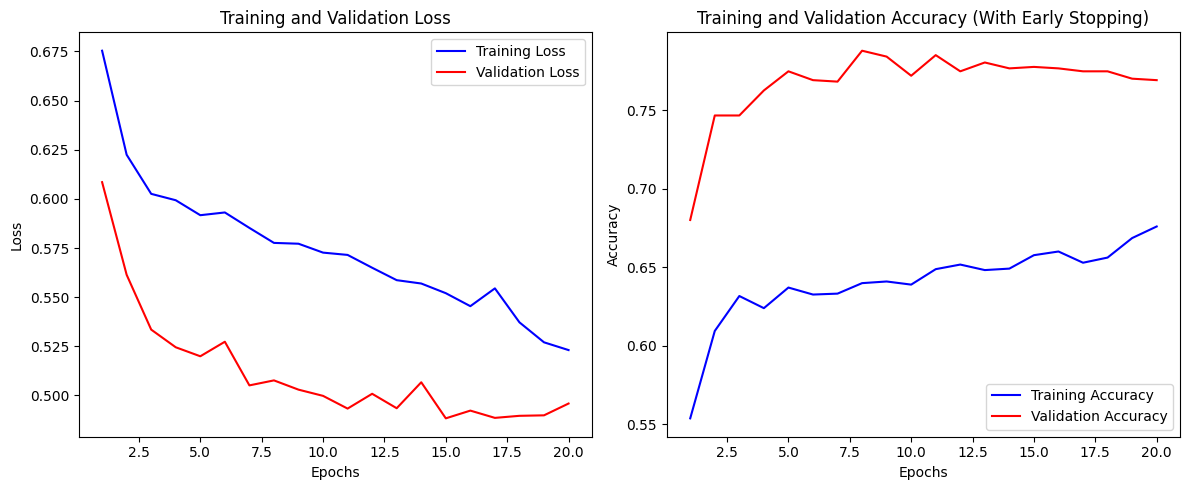

In [19]:
# Plot the results
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy (With Early Stopping)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()